In [2]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [13]:
results = {}

In [27]:
def add_attractor(ax, y: np.ndarray, type, threshold: int=0, label=None, color='blue', linestyle='solid', marker=None):
    assert type in ['X-Y', 'X-Z', 'Y-Z']

    if type == 'X-Y': 
        ax.plot(y[threshold:, 0], y[threshold:, 1], label=label, color=color, linestyle=linestyle, marker=marker)
    elif type == 'X-Z':
        ax.plot(y[threshold:, 0], y[threshold:, 2], label=label, color=color, linestyle=linestyle, marker=marker)
    else:
        ax.plot(y[threshold:, 1], y[threshold:, 2], label=label, color=color, linestyle=linestyle, marker=marker)

    if label is not None:
        ax.legend()
    ax.set_title(f'({type})')
    ax.set_xlabel(type[0])
    ax.set_ylabel(type[2])
    ax.grid(True, linestyle='--')

# ================================================================================

def add_attractors(axes, y: np.ndarray, threshold: int = 0, label=None, color='blue', linestyle='solid', marker=None):
    add_attractor(axes[0], y, 'X-Y', threshold=threshold, label=label, color=color, linestyle=linestyle, marker=marker)
    add_attractor(axes[1], y, 'X-Z', threshold=threshold, label=label, color=color, linestyle=linestyle, marker=marker)
    add_attractor(axes[2], y, 'Y-Z', threshold=threshold, label=label, color=color, linestyle=linestyle, marker=marker)    

In [25]:
def get_results(tmin, tmax, dt, method):
    key = (tmin, tmax, dt)

    if key in results.keys():
        if method in results[key].keys():
            return results[key][method]
        else:
            print('Error: no such method in results')
            return None
    else:
        print('Error: no such (tmin, tmax, dt) in results')
        return None

# Чтение результатов

In [17]:
def extract_time_parameters(target_dir_name):
    # expecsts folder name like "0_100_0-001"
    # where 0 is tmin
    # 100 is tmax
    # and 0.001 is dt
    
    parts = target_dir_name.split('_')

    return \
        int(parts[0]), \
        int(parts[1]), \
        float(parts[2].replace('-', '.'))

In [66]:
results_dir = Path(os.getcwd()) / 'results'

# Load the results
for item in results_dir.iterdir():
    if item.is_dir():
        sub_results = {}
        
        for item2 in item.iterdir():
            if item2.is_file():
                sub_results[item2.stem] = np.load(item2, allow_pickle=False)

        tmin, tmax, dt = extract_time_parameters(item.name)
        results[(tmin, tmax, dt)] = sub_results

# print results structure
for t, sub_results in results.items():
    print(f"[{t[0]}, {t[1]}] dt={t[2]}")
    for key, value in sub_results.items():
        print(f"\t{key.ljust(20)} -> {value.shape}")

[0, 100] dt=0.0001
	cd-lorenz            -> (1000001, 3)
	euler-cromer         -> (1000001, 3)
	euler                -> (1000001, 3)
	midpoint             -> (1000001, 3)
	runge-kutta-4        -> (1000001, 3)
[0, 100] dt=0.001
	cd-lorenz            -> (100001, 3)
	euler-cromer         -> (100001, 3)
	euler                -> (100001, 3)
	midpoint             -> (100001, 3)
	runge-kutta-4        -> (100001, 3)
[0, 100] dt=0.01
	cd-lorenz            -> (10001, 3)
	euler-cromer         -> (10001, 3)
	euler                -> (10001, 3)
	midpoint             -> (10001, 3)
	runge-kutta-4        -> (10001, 3)
[0, 10] dt=1e-05
	cd-lorenz            -> (1000001, 3)
	euler-cromer         -> (1000001, 3)
	euler                -> (1000001, 3)
	midpoint             -> (1000001, 3)
	runge-kutta-4        -> (1000001, 3)
[0, 10] dt=0.0001
	cd-lorenz            -> (100001, 3)
	euler-cromer         -> (100001, 3)
	euler                -> (100001, 3)
	midpoint             -> (100001, 3)
	runge-kutta-4    

# Построение аттракторов

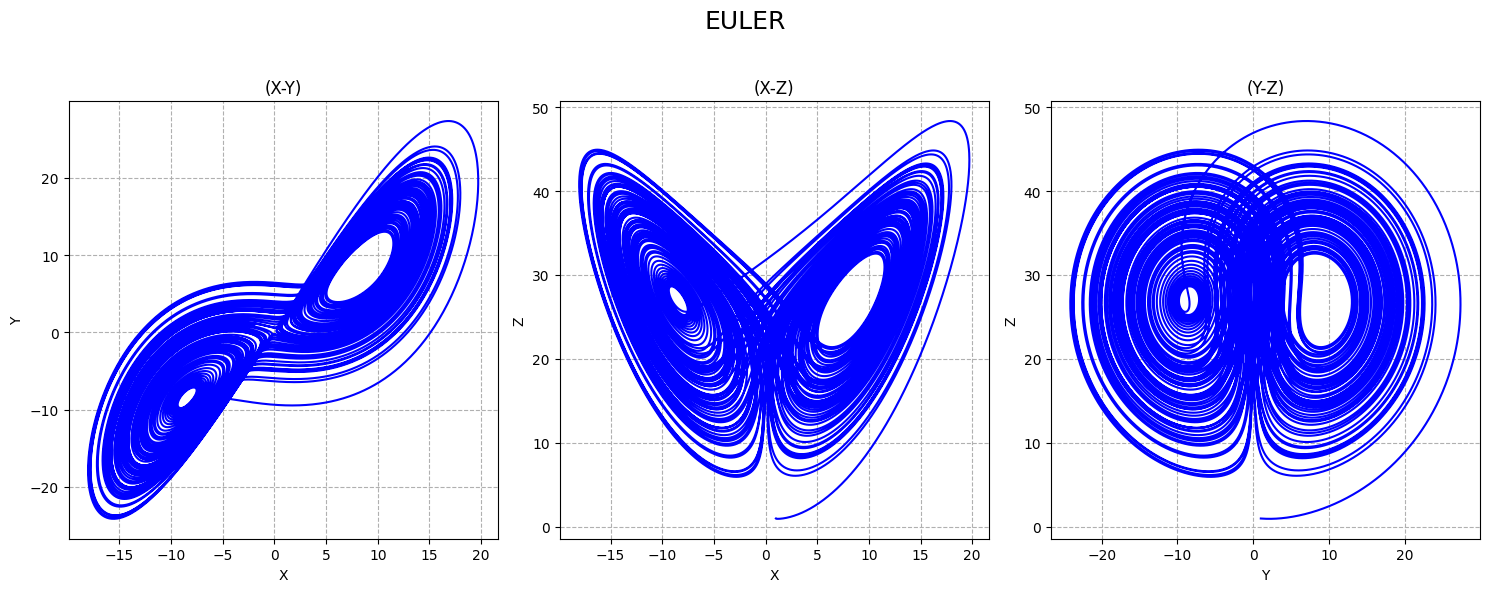

In [28]:
method = "euler"
tmin, tmax, dt = 0, 100, 0.001

y = get_results(tmin, tmax, dt, method)

if y is not None:
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    fig.suptitle(f"{method.upper()}\n", fontsize=18)


    add_attractors(
        axes=axes,
        y = y,#results[(tmin, tmax, dt)][method], 
        threshold=0,
        color='blue'
    )

    plt.tight_layout()
    plt.show()

# Построение аттракторов в сравнении с Рунге-Кутта 4

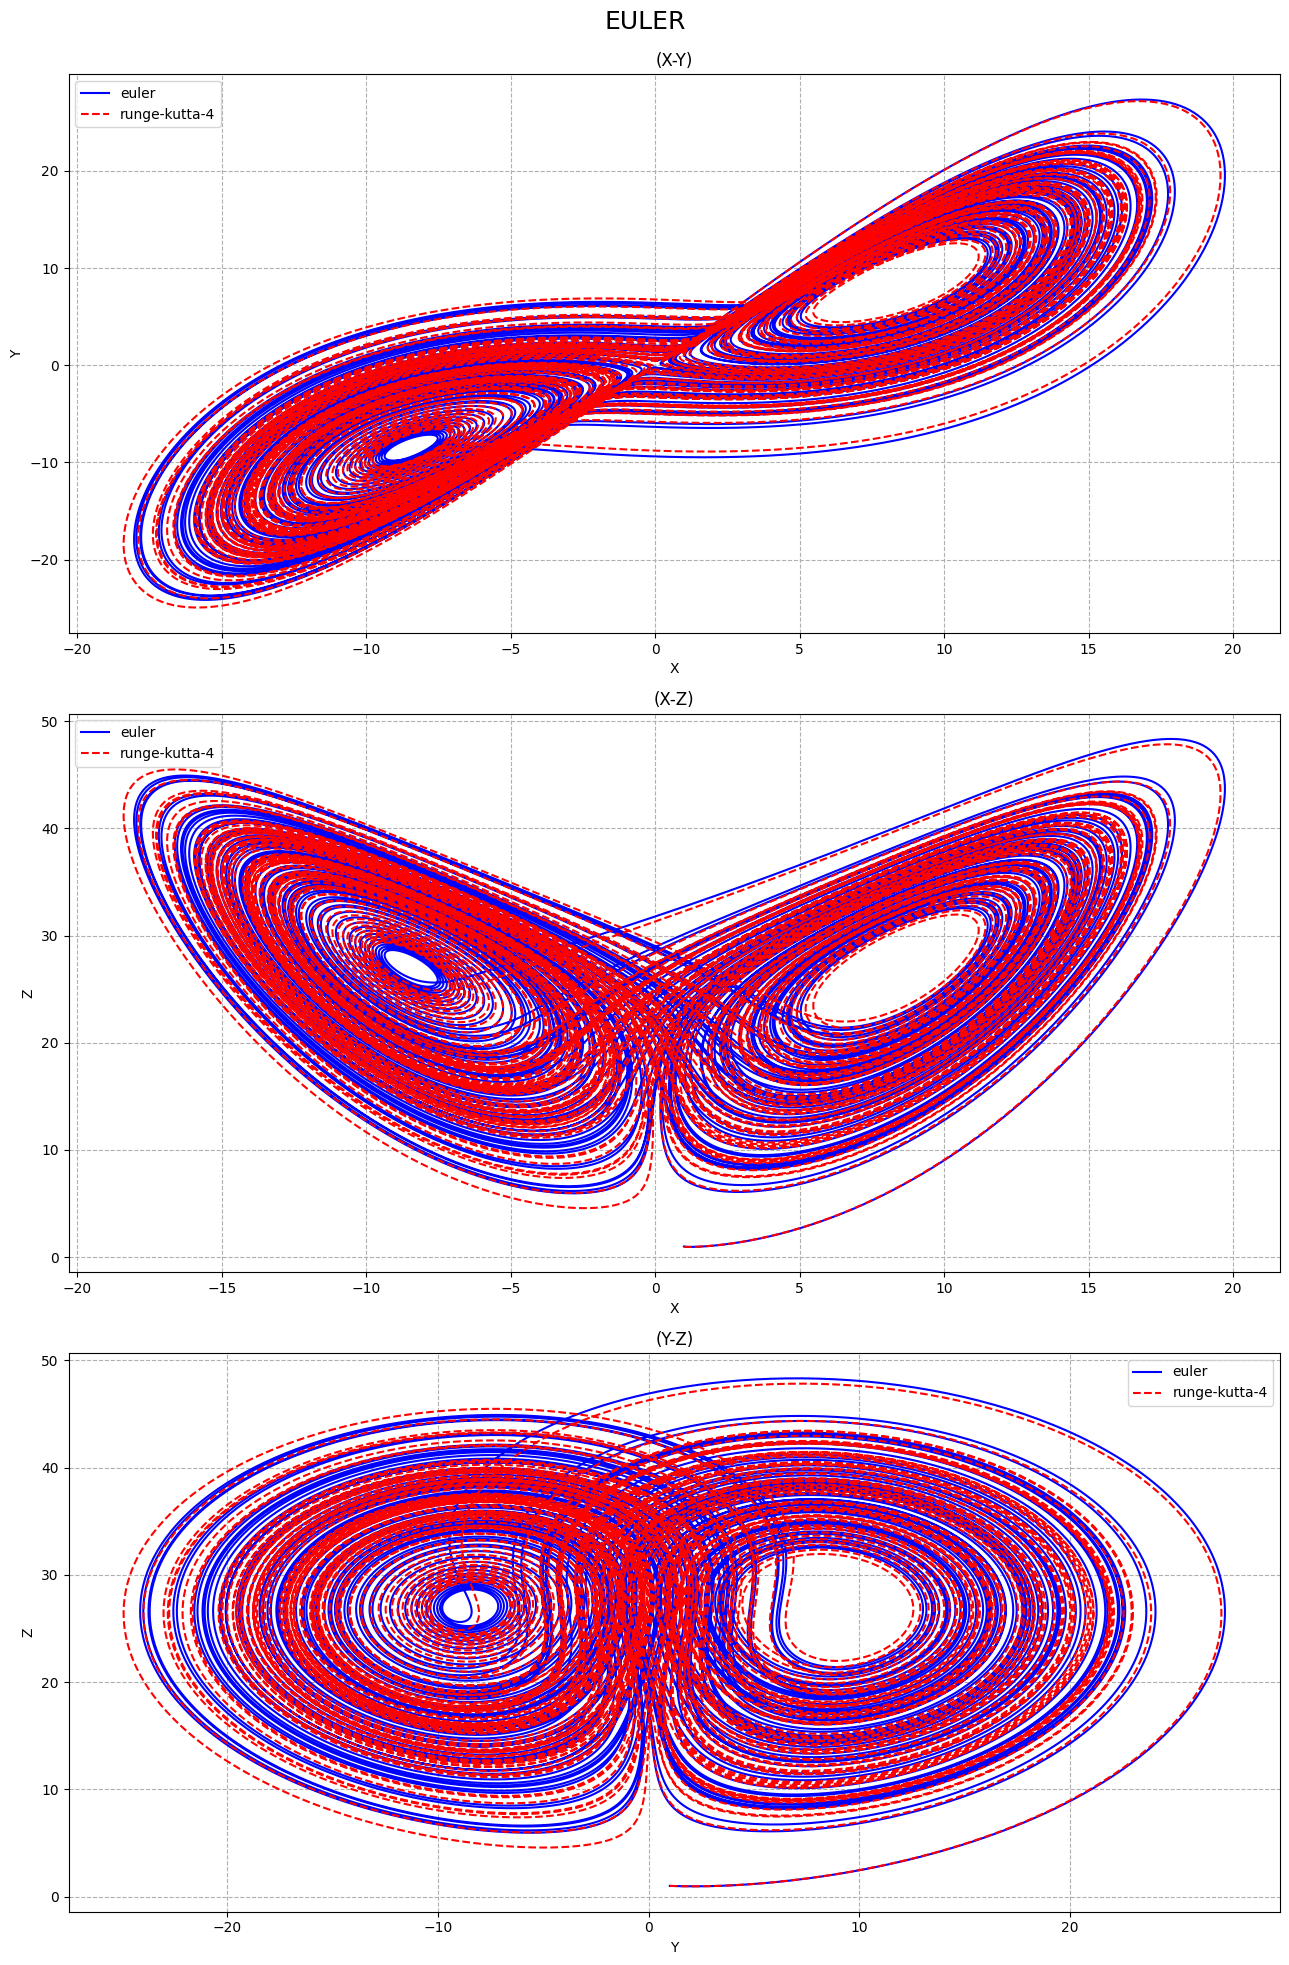

In [29]:
# show attractors of specified method compared to rk-4

source_method = 'euler'
target_method = 'runge-kutta-4'
tmin, tmax, dt = 0, 100, 0.001

source_y = get_results(tmin, tmax, dt, source_method)
target_y = get_results(tmin, tmax, dt, target_method)

if (source_y is not None) and (target_y is not None):
    fig, axes = plt.subplots(3, 1, figsize=(13, 20))
    fig.suptitle(f"{method.upper()}\n", fontsize=18)

    add_attractors(
        axes=axes,
        y = results[(tmin, tmax, dt)][source_method], 
        threshold=0,
        label=source_method,
        color='blue'
    )
    add_attractors(
        axes=axes,
        y = results[(tmin, tmax, dt)][target_method], 
        threshold=0,
        color='red',
        label=target_method,
        linestyle='--'
    )

    plt.tight_layout()
    plt.show()

# Построение графиков ошибки

In [36]:
def downsample_to_n(x, n):
    if len(x) <= n:
        return x
    step = len(x) / n
    indices = np.arange(0, n) * step
    return x[np.floor(indices).astype(int)]

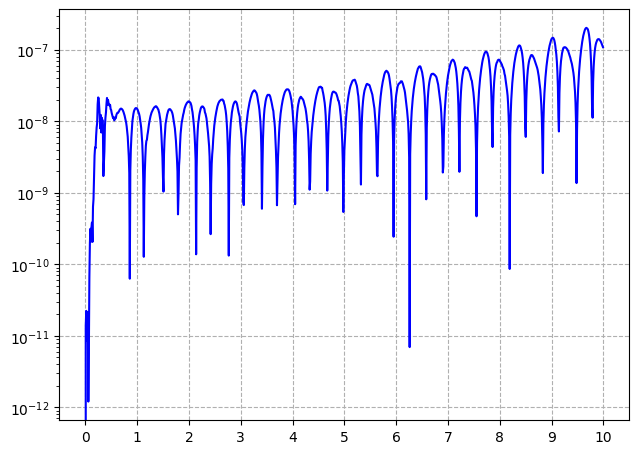

In [68]:
source_method = 'runge-kutta-4'
target_method = 'runge-kutta-4'
tmin, tmax = 0, 10
source_dt = 0.0001
target_dt = 0.00001

graphic_points = 1000

source_y = get_results(tmin, tmax, source_dt, source_method)
target_y = get_results(tmin, tmax, target_dt, target_method)

if (source_y is not None) and (target_y is not None):
    target_step = int(source_dt / target_dt)
    loss = np.abs(source_y - target_y[::target_step])

    t = np.arange(tmin, tmax + source_dt, source_dt)

    plt.plot(downsample_to_n(t, graphic_points), downsample_to_n(loss[:, 2], graphic_points), color='blue')

    plt.tight_layout()
    plt.grid(True, linestyle='--')
    plt.xticks(np.arange(tmin, tmax + 1, 1))
    plt.yscale('log')
    plt.show()

In [69]:
print("X:")
print(f"Средняя ошибка: {np.mean(loss[:, 0])}")
print(f"Максимальная ошибка: {np.max(loss[:, 0])}")
print(f"Минимальная ошибка: {np.min(loss[:, 0])}")

print("Y:")
print(f"Средняя ошибка: {np.mean(loss[:, 1])}")
print(f"Максимальная ошибка: {np.max(loss[:, 1])}")
print(f"Минимальная ошибка: {np.min(loss[:, 1])}")

print("Z:")
print(f"Средняя ошибка: {np.mean(loss[:, 2])}")
print(f"Максимальная ошибка: {np.max(loss[:, 2])}")
print(f"Минимальная ошибка: {np.min(loss[:, 2])}")

X:
Средняя ошибка: 1.7782518805561304e-08
Максимальная ошибка: 1.011302241948897e-07
Минимальная ошибка: 0.0
Y:
Средняя ошибка: 2.5490804435512045e-08
Максимальная ошибка: 1.7413825759149404e-07
Минимальная ошибка: 0.0
Z:
Средняя ошибка: 3.227147092954474e-08
Максимальная ошибка: 2.0362790209560444e-07
Минимальная ошибка: 0.0


### DBSCAN


In [ ]:
# DBSCAN